In [1]:
import pennylane as qml
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# Variational Quantum Classifier as a PyTorch module
class noisy_VQC(nn.Module):
    def __init__(self, num_shots, p_noise):
        super().__init__()
        self.num_shots = num_shots
        self.p_noise = p_noise
        # Initialize the weights as trainable parameters
        self.num_params = 1
        self.params = np.round(np.random.uniform(0, np.pi*2, self.num_params), 5)
        self.weights = nn.Parameter(torch.tensor(self.params, dtype=torch.float64))
        print(f"Param check {self.params}")

        # Device setup
        print(self.num_shots, type(self.num_shots))
        self.dev = qml.device("default.mixed", wires=1, shots=self.num_shots)

        # Define the QNode with torch interface
        self.qnode = qml.QNode(self.quantum_circuit, self.dev, interface="torch")

    def quantum_circuit(self, d, label, weights):
        if label == 0:
            qml.RY(d, wires=0)
        else:
            qml.Hadamard(wires=0)
            qml.RZ(d, wires=0)
            qml.RY(d, wires=0)

        # Apply depolarizing noise after state preparation
        qml.DepolarizingChannel(p=self.p_noise, wires=0)  # you can vary p later

        for param_index in range(self.num_params):
            qml.RY(weights[param_index], wires=0)

        return qml.expval(qml.PauliZ(0))

    def forward(self, d, label):
        expval = self.qnode(d, label, self.weights)
        prob = (1 - expval) / 2  # map [-1, 1] to [0, 1]
        return prob

In [3]:
class Client:
    def __init__(self, sigma, num_samples, seed, vqc_class, noise_angle=0.0, target_class0_ratio=None):
        self.sigma = sigma
        self.num_samples = num_samples
        self.seed = seed
        self.target_class0_ratio = target_class0_ratio
        self.model = vqc_class
        self.noise_angle = noise_angle
        self.labels = self._generate_labels()
        self.sample_pointer = 0  
        self.local_weights_evolution = []
        

    def _generate_labels(self):
        """
        Generate labels for this client with class imbalance based on sigma.
        """
        np.random.seed(self.seed)
        
        if self.target_class0_ratio is not None:
            num_class0 = int(round(self.num_samples * self.target_class0_ratio))
            num_class1 = self.num_samples - num_class0
            labels = np.array([0] * num_class0 + [1] * num_class1)
            np.random.shuffle(labels)
        else:
            raw_bias = np.random.normal(0, self.sigma)
            prob_class_0 = 1 / (1 + np.exp(-raw_bias))  # sigmoid
            labels = np.random.choice([0, 1], size=self.num_samples, p=[prob_class_0, 1 - prob_class_0])
    
        return labels
        

    def get_label_distribution(self):
        """
        Returns the proportion of class 0 and class 1.
        """
        prop_class_0 = np.mean(self.labels == 0)
        prop_class_1 = 1 - prop_class_0
        return {'class_0': prop_class_0, 'class_1': prop_class_1}
        

    def set_weights(self, new_weights):
        with torch.no_grad():
            self.model.weights.copy_(torch.tensor(new_weights, dtype=torch.float64))

    
    def get_weights(self):
        return self.model.weights.detach().numpy()
            

    def local_train(self, round_batch_size=20, local_batch_size=5, lr=0.1):
        # Select next batch
        start = self.sample_pointer
        end = min(start + round_batch_size, self.num_samples)
        self.sample_pointer = end
    
        if end - start == 0:
            return self.get_weights()  # No more data
    
        x_batch = [self.noise_angle] * (end - start)
        y_batch = self.labels[start:end]
    
        x_batch = torch.tensor(x_batch, dtype=torch.float64)
        y_batch = torch.tensor(y_batch, dtype=torch.float64)
    
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        loss_fn = nn.BCELoss()

        local_weights_evolution_aux = []
    
        # Split into local batches and update model
        for i in range(0, len(x_batch), local_batch_size):
            xb = x_batch[i:i+local_batch_size]
            yb = y_batch[i:i+local_batch_size]
    
            optimizer.zero_grad()
            outputs = torch.stack([self.model(x, int(label)) for x, label in zip(xb, yb)])
            loss = loss_fn(outputs, yb)
            loss.backward()
            optimizer.step()

            weight = self.get_weights().copy()
            print("Updated parameters to:",weight)
            local_weights_evolution_aux.append(weight[0])
        self.local_weights_evolution.append(local_weights_evolution_aux)
    
        return self.get_weights()

In [4]:
def create_clients_setup(num_clients=5, num_samples=100, sigma_range=(0.5, 2.0), seed=0, vqc_class=None, target_class0_ratio=None):
    np.random.seed(seed)
    clients = []

    for i in range(num_clients):
        sigma = np.random.uniform(*sigma_range)
        client_seed = seed + i
        client = Client(sigma=sigma, 
                        num_samples=num_samples, 
                        seed=client_seed, 
                        vqc_class=vqc_class,
                        target_class0_ratio=target_class0_ratio)
        clients.append(client)

    return clients

In [5]:
def average_angles_modulo(weights_list):
    angles = np.array(weights_list)
    x = np.cos(angles)
    y = np.sin(angles)

    mean_x = np.mean(x)
    mean_y = np.mean(y)

    mean_angle = np.arctan2(mean_y, mean_x)
    return mean_angle % (2 * np.pi)

In [6]:
def run_federated_training(clients, num_rounds, round_batch_size=20, local_batch_size=5, lr=0.1):
    global_weights_evolution = []
    for rnd in range(num_rounds):
        print(f"\n--- Round {rnd+1} ---")

        local_weights = []

        for client in clients:
            weights = client.local_train(round_batch_size=round_batch_size, local_batch_size=local_batch_size, lr=lr)
            local_weights.append(weights)

        for client in clients:
            for param in client.model.parameters():
                print(param)

        # Federated averaging
        global_weights = average_angles_modulo(local_weights)
        global_weights_evolution.append(global_weights)
        print(f"Local weights: {local_weights}, Average: {global_weights}")

        # Broadcast new weights
        for client in clients:
            client.set_weights(global_weights)

    return global_weights_evolution

In [7]:
def evaluate_clients(clients, num_test_samples=10000, noise_angle=0.0, seed=None):

    print(f"Evaluating Clients...")

    def generate_balanced_labels(num_samples, seed=None):
        if seed is not None:
            np.random.seed(seed)
    
        half = num_samples // 2
        labels = np.array([0]*half + [1]*half)
        np.random.shuffle(labels)
        return labels
        
    test_labels = generate_balanced_labels(num_test_samples, seed=seed)
    x_test = torch.tensor([noise_angle] * num_test_samples, dtype=torch.float64)

    accuracies = {}

    for i, client in enumerate(clients):
        client.model.eval()
        with torch.no_grad():
            outputs = torch.stack([client.model(x, int(label)) for x, label in zip(x_test, test_labels)])
            predictions = (outputs >= 0.5).int()
            labels = torch.tensor(test_labels, dtype=torch.int)
            accuracy = (predictions == labels).float().mean().item()
            accuracies[client] = accuracy
        print(f"Client{i} got an accuracy of {accuracy}")

    return accuracies

In [8]:
def angular_distance(theta, theta_opt):
    """Returns shortest angular distance between angles in radians."""
    theta = np.asarray(theta)
    diff = np.abs(theta - theta_opt) % (2 * np.pi)
    return np.minimum(diff, 2 * np.pi - diff)

In [9]:
opt_rot_list = []
ratio_distance = {}
noise_distance = {}

for sigma in [4.0]:
    for p_noise in [0.0, 0.05, 0.1, 0.3, 0.5]:
        distances = []
        for random_seed in np.arange(1, 51):
            client = create_clients_setup(num_clients=1, 
                                          num_samples=100, 
                                          sigma_range=(sigma, sigma), 
                                          seed=random_seed,
                                          vqc_class=noisy_VQC(num_shots=1, p_noise=p_noise),
                                          target_class0_ratio = None)[0]
            client.local_train(round_batch_size=client.num_samples, local_batch_size=1)
            optimal_rot = client.local_weights_evolution[0][-1]
            opt_rot_list.append(optimal_rot)
            distance = angular_distance(optimal_rot, 0.78)
            distances.append(distance)
        #ratio_distance[f"ratio_{ratio}"] = distances
        noise_distance[f"noise_{p_noise}"] = distances

Param check [3.01934]
1 <class 'int'>
Updated parameters to: [3.01934]
Updated parameters to: [3.09375368]
Updated parameters to: [3.08923546]
Updated parameters to: [3.05264607]
Updated parameters to: [2.99857482]
Updated parameters to: [2.9519724]
Updated parameters to: [2.89290607]
Updated parameters to: [2.82511634]
Updated parameters to: [2.78792384]
Updated parameters to: [2.75473039]
Updated parameters to: [2.72498282]
Updated parameters to: [2.69823572]
Updated parameters to: [2.6585937]
Updated parameters to: [2.60866889]
Updated parameters to: [2.5504004]
Updated parameters to: [2.48526835]
Updated parameters to: [2.42617436]
Updated parameters to: [2.36040255]
Updated parameters to: [2.28901643]
Updated parameters to: [2.21287706]
Updated parameters to: [2.14360057]
Updated parameters to: [2.06927158]
Updated parameters to: [2.00159411]
Updated parameters to: [1.93995812]
Updated parameters to: [1.8721497]
Updated parameters to: [1.79902147]
Updated parameters to: [1.7323956

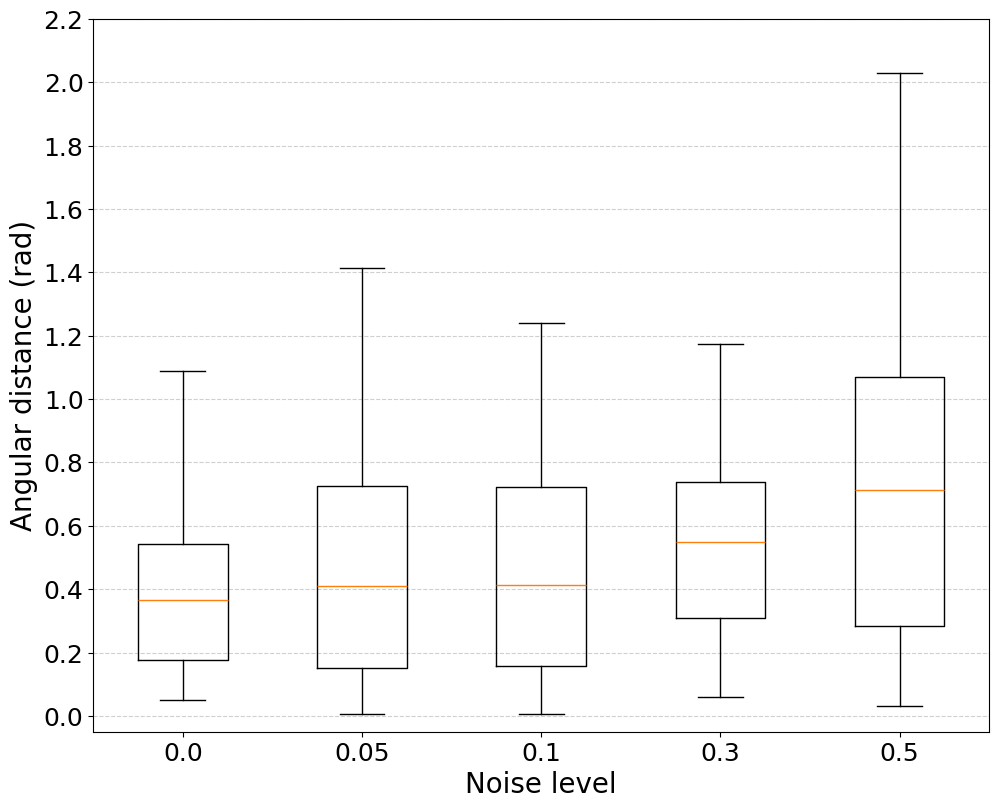

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_ylabel("Angular distance (rad)", fontsize=20)

# Sorted to keep x-axis ordered
ratios = sorted(noise_distance.keys())
data = [noise_distance[noise] for noise in ["noise_0.0", "noise_0.05", "noise_0.1", "noise_0.3", 
                                            "noise_0.5"]]

# Hide outliers with `showfliers=False`
ax.boxplot(data, tick_labels=[0.0, 0.05, 0.1, 0.3, 0.5], showfliers=False)

ax.set_xlabel("Noise level", fontsize=20)
#ax.set_title(f"Angular distances per noise level with σ={sigma}", fontsize=20)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.yticks(np.arange(0, 2.4, 0.2))
ax.tick_params(axis='both', labelsize=18)
plt.ylim(bottom=-0.05)
plt.savefig(f"figs/noise_level_sigma{sigma}.png", dpi=300, bbox_inches='tight')
plt.show()

In [11]:
opt_rot_list = []
ratio_distance = {}
noise_distance = {}

for sigma in [0.0]:
    for p_noise in [0.0, 0.05, 0.1, 0.3, 0.5]:
        distances = []
        for random_seed in np.arange(1, 51):
            client = create_clients_setup(num_clients=1, 
                                          num_samples=100, 
                                          sigma_range=(sigma, sigma), 
                                          seed=random_seed,
                                          vqc_class=noisy_VQC(num_shots=1, p_noise=p_noise),
                                          target_class0_ratio = None)[0]
            client.local_train(round_batch_size=client.num_samples, local_batch_size=1)
            optimal_rot = client.local_weights_evolution[0][-1]
            opt_rot_list.append(optimal_rot)
            distance = angular_distance(optimal_rot, 0.78)
            distances.append(distance)
        #ratio_distance[f"ratio_{ratio}"] = distances
        noise_distance[f"noise_{p_noise}"] = distances

Param check [2.56492]
1 <class 'int'>
Updated parameters to: [2.56492]
Updated parameters to: [2.56492]
Updated parameters to: [2.50103864]
Updated parameters to: [2.42294435]
Updated parameters to: [2.35693687]
Updated parameters to: [2.28033621]
Updated parameters to: [2.19707799]
Updated parameters to: [2.12368087]
Updated parameters to: [2.0585236]
Updated parameters to: [2.00037223]
Updated parameters to: [1.93217414]
Updated parameters to: [1.87085482]
Updated parameters to: [1.81557533]
Updated parameters to: [1.76563482]
Updated parameters to: [1.72043976]
Updated parameters to: [1.67948163]
Updated parameters to: [1.62537731]
Updated parameters to: [1.56105174]
Updated parameters to: [1.50258985]
Updated parameters to: [1.44942408]
Updated parameters to: [1.40105046]
Updated parameters to: [1.35701946]
Updated parameters to: [1.31692869]
Updated parameters to: [1.28041677]
Updated parameters to: [1.2471583]
Updated parameters to: [1.21685956]
Updated parameters to: [1.17153775

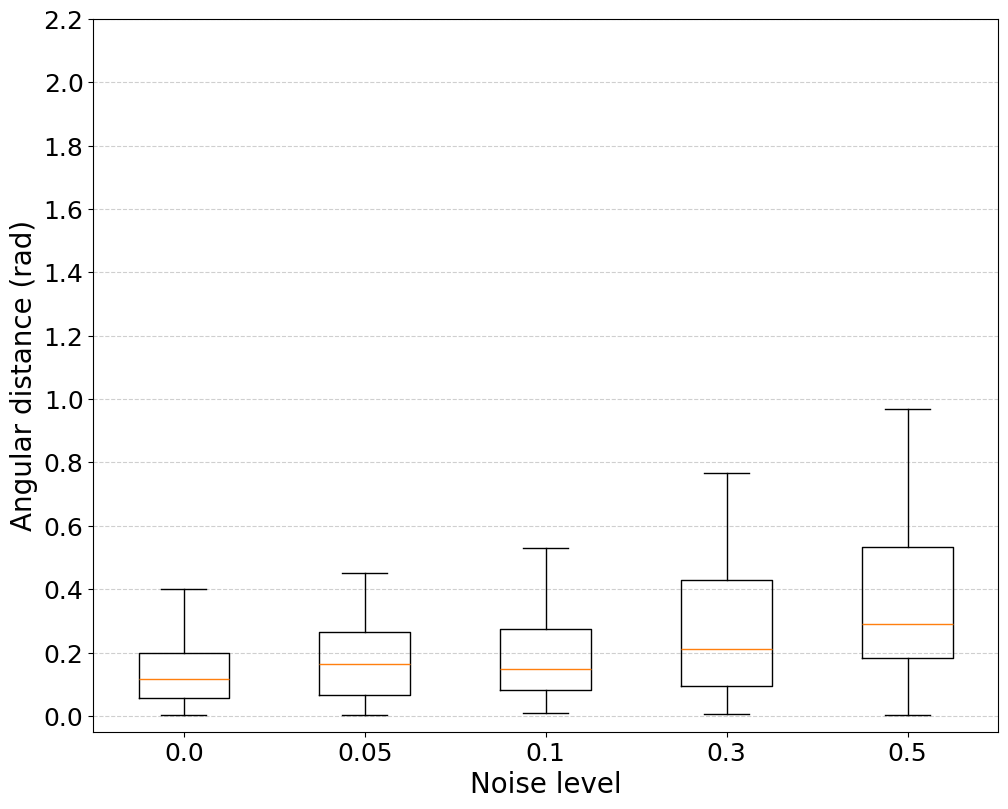

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_ylabel("Angular distance (rad)", fontsize=20)

# Sorted to keep x-axis ordered
ratios = sorted(noise_distance.keys())
data = [noise_distance[noise] for noise in ["noise_0.0", "noise_0.05", "noise_0.1", "noise_0.3", 
                                            "noise_0.5"]]

# Hide outliers with `showfliers=False`
ax.boxplot(data, tick_labels=[0.0, 0.05, 0.1, 0.3, 0.5], showfliers=False)

ax.set_xlabel("Noise level", fontsize=20)
#ax.set_title(f"Angular distances per noise level with σ={sigma}", fontsize=20)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.yticks(np.arange(0, 2.4, 0.2))
ax.tick_params(axis='both', labelsize=18)
plt.ylim(bottom=-0.05)
plt.savefig(f"figs/noise_level_sigma{sigma}.png", dpi=300, bbox_inches='tight')
plt.show()

In [13]:
all_global_weights = []
p_noise = 0.5
for random_seed in np.arange(1, 51):
    clients = create_clients_setup(num_clients=20, 
                                  num_samples=100, 
                                  sigma_range=(4., 4.), 
                                  seed=random_seed,
                                  vqc_class=noisy_VQC(num_shots=1, p_noise=p_noise),
                                  target_class0_ratio = None)
    global_weights_evolution = run_federated_training(clients, num_rounds=20, round_batch_size=5, local_batch_size=5)
    all_global_weights.append(global_weights_evolution)

Param check [2.56492]
1 <class 'int'>

--- Round 1 ---
Updated parameters to: [2.46492]
Updated parameters to: [2.46492]
Updated parameters to: [2.36492]
Updated parameters to: [2.46492]
Updated parameters to: [2.46492]
Updated parameters to: [2.36492]
Updated parameters to: [2.26492]
Updated parameters to: [2.26492]
Updated parameters to: [2.16492]
Updated parameters to: [2.16492]
Updated parameters to: [2.06492]
Updated parameters to: [2.06492]
Updated parameters to: [1.96492]
Updated parameters to: [1.96492]
Updated parameters to: [1.96492]
Updated parameters to: [1.86492]
Updated parameters to: [1.76492]
Updated parameters to: [1.86492]
Updated parameters to: [1.76492]
Updated parameters to: [1.86492]
Parameter containing:
tensor([1.8649], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([1.8649], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([1.8649], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([1.8649], dtype=

In [14]:
# Convert to a NumPy array
arr = np.array(all_global_weights)  # Shape: (num_experiments, num_rounds)

# Compute element-wise mean and std across experiments
mean_array = np.mean(arr, axis=0)
std_array = np.std(arr, axis=0)

print("Mean per round:", mean_array)
print("Std per round:", std_array)

Mean per round: [2.18999368 1.59933886 0.99702033 0.98102033 0.87935662 0.86335662
 0.80535662 0.77335662 0.77735662 0.86935662 0.83335662 0.99902033
 0.87335662 0.89535662 0.99302033 0.97502033 0.98302033 0.83535662
 0.86935662 0.91935662]
Std per round: [1.8133688  1.6938461  0.86531617 0.88143282 0.39508944 0.33067256
 0.32702511 0.37054988 0.333244   0.273932   0.2996188  0.8072822
 0.29645766 0.31820687 0.78989657 0.79252146 0.82645084 0.39190663
 0.34150406 0.30114904]


In [15]:
new_arr = angular_distance(arr, 0.78)

In [16]:
mean_array = np.mean(new_arr, axis=0)
std_array = np.std(new_arr, axis=0)

print("Mean per round:", mean_array)
print("Std per round:", std_array)

Mean per round: [0.93601106 0.57095096 0.37675933 0.33258451 0.30815552 0.25931771
 0.25244029 0.29820469 0.28915107 0.22174328 0.25366446 0.28419304
 0.24476669 0.29200166 0.28802664 0.30897829 0.31746688 0.33642629
 0.29253566 0.28438886]
Std per round: [0.81624758 0.62016016 0.39851032 0.34061538 0.26647247 0.22146556
 0.20943323 0.22005752 0.16568106 0.18399256 0.16814487 0.18491176
 0.19155121 0.17116598 0.22994113 0.20881513 0.21479224 0.20850063
 0.1975665  0.1709795 ]


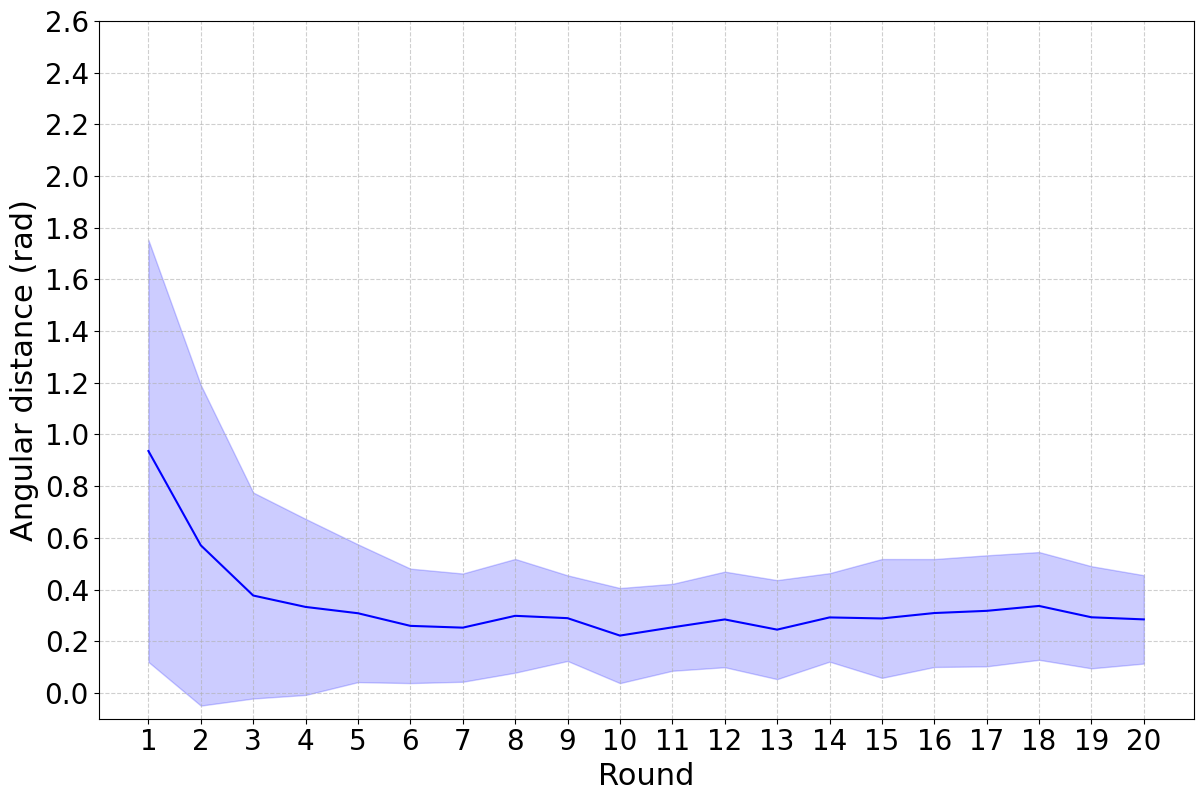

In [17]:
rounds = np.arange(1, 21)

# Plot
plt.figure(figsize=(12, 8))
plt.plot(rounds, mean_array, color='blue', label='Mean Global Weight')
plt.fill_between(rounds,
                 mean_array - std_array,
                 mean_array + std_array,
                 color='blue',
                 alpha=0.2,
                 label='± Std Dev')

plt.xlabel("Round", fontsize=22)
plt.ylabel("Angular distance (rad)", fontsize=22)
#plt.title("Average QFL Evolution", fontsize=22)
plt.xticks(rounds,fontsize=20)
plt.grid(True, linestyle='--', alpha=0.6)
#plt.legend()
plt.tight_layout()
plt.yticks(np.arange(0., 2.8, 0.2), fontsize=20)
plt.ylim(bottom=-0.1)
plt.savefig("figs/global_noise05_sigma4.png", dpi=300, bbox_inches='tight')
plt.show()

In [18]:
local_results = []
p_noise = 0.5
for random_seed in np.arange(1,51):
    clients = create_clients_setup(num_clients=10, 
                                  num_samples=100, 
                                  sigma_range=(4., 4.), 
                                  seed=random_seed,
                                  vqc_class=noisy_VQC(num_shots=1, p_noise=p_noise),
                                  target_class0_ratio = None)
    local_weights_list = []
    for client in clients:
        client.local_train(round_batch_size=client.num_samples, local_batch_size=1)
        local_weights_list.append(client.local_weights_evolution[0])
    local_results.append(local_weights_list)

Param check [3.67133]
1 <class 'int'>
Updated parameters to: [3.67133]
Updated parameters to: [3.67133]
Updated parameters to: [3.67133]
Updated parameters to: [3.67133]
Updated parameters to: [3.67133]
Updated parameters to: [3.67133]
Updated parameters to: [3.67133]
Updated parameters to: [3.67133]
Updated parameters to: [3.62245458]
Updated parameters to: [3.57883439]
Updated parameters to: [3.5397425]
Updated parameters to: [3.5045936]
Updated parameters to: [3.47290679]
Updated parameters to: [3.44428035]
Updated parameters to: [3.39157158]
Updated parameters to: [3.34380413]
Updated parameters to: [3.33695014]
Updated parameters to: [3.33072571]
Updated parameters to: [3.32506867]
Updated parameters to: [3.31992411]
Updated parameters to: [3.31524326]
Updated parameters to: [3.28559857]
Updated parameters to: [3.25860671]
Updated parameters to: [3.23402439]
Updated parameters to: [3.2116325]
Updated parameters to: [3.21773205]
Updated parameters to: [3.22328924]
Updated parameter

In [19]:
len(local_results[0][0])

100

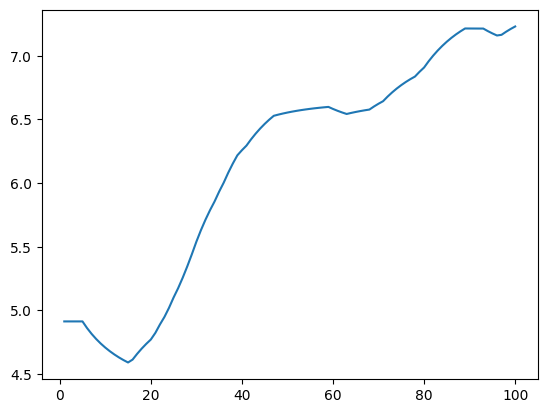

In [20]:
plt.plot(np.arange(1,101), local_results[1][0])

In [21]:
client_distance = angular_distance(local_results, 0.78)

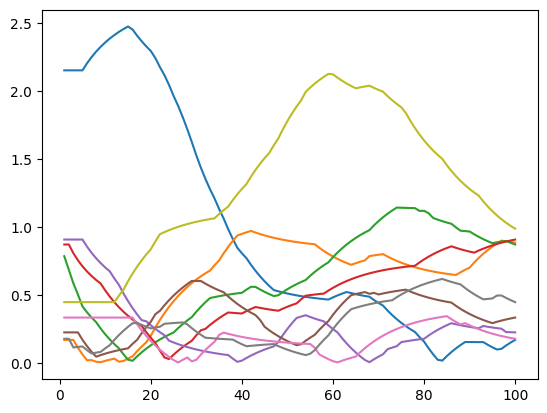

In [22]:
for client in np.arange(0,9):
    plt.plot(np.arange(1,101), client_distance[1][client])

In [23]:
# Assuming your data is stored in a NumPy array called `data`
# Shape: (19, 10, 100)
data = np.array(client_distance)  # Replace `your_list` with your actual variable

# Average over the first axis (19 experiments)
mean_per_client = np.mean(data, axis=0)  # Shape: (10, 100)

In [24]:
std_per_client = np.std(data, axis=0)  # Shape: (10, 100)

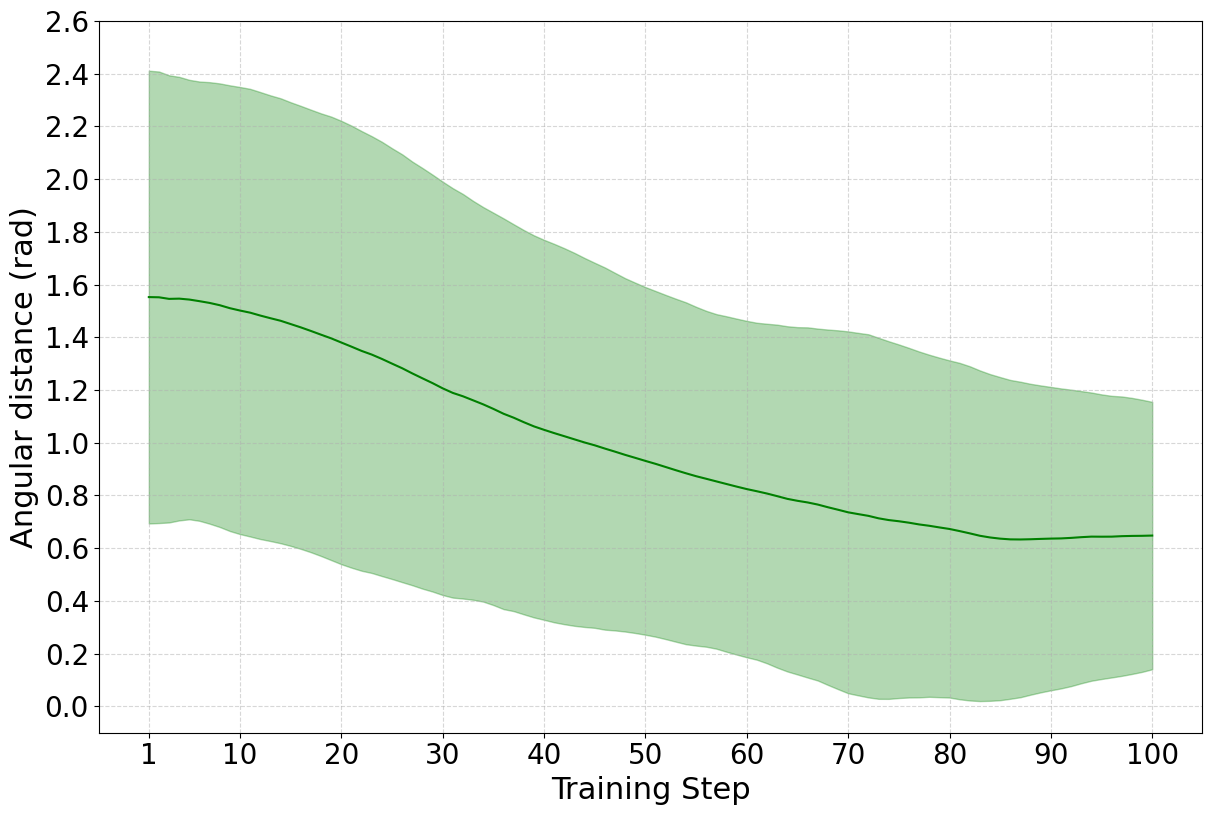

In [25]:
client_id = 0  # Choose client 0 through 9
rounds = np.arange(1,101)

plt.figure(figsize=(12, 8))
plt.plot(rounds, mean_per_client[client_id], label=f"Client {client_id} Mean", color='green')
plt.fill_between(rounds,
                 mean_per_client[client_id] - std_per_client[client_id],
                 mean_per_client[client_id] + std_per_client[client_id],
                 color='green', alpha=0.3, label='±1 Std Dev')

#plt.title(f"Average Local Evolution - Client {client_id+1}",  fontsize=22)
plt.xlabel("Training Step",  fontsize=22)
plt.ylabel("Angular distance (rad)",  fontsize=22)
#plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.yticks(np.arange(0., 2.8, 0.2), fontsize=20)
plt.xticks([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],  fontsize=20)
plt.ylim(bottom=-0.1)
plt.savefig("figs/local_noise05_sigma4.png", dpi=300, bbox_inches='tight')
plt.show()